In [6]:
# dit is voor directory binnen google colab
# %cd drive/MyDrive/Colab\ Notebooks

/content/drive/MyDrive/Colab Notebooks


In [125]:
# nog toe te voegen voor wie lokaal runt
# is GPU toevoeging.....

In [153]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
import numpy as np
import cv2
import pandas as pd
import os
import glob
from matplotlib import pyplot as plt

In [113]:
train_df = pd.read_csv("train_labels.csv")

In [152]:
# retrieve label for image
def get_image_label(image_name, train_df):
  return train_df[train_df.img_name == image_name].label.values[0]

# transform image
def image_to_feature(image, size=(224,224)):
  # resize image to size, flatten to list (need to happen)
  image = cv2.resize(image,size).flatten()
  return image

In [150]:
# change list directory if necessary
image_paths_train = ["train_set/"+file for file in os.listdir("train_set")]

raw_images = []
labels = []

for i, image_path in enumerate(image_paths_train):
  image = cv2.imread(image_path)
  label = get_image_label(image_path[10:], train_df)

  features = image_to_feature(image)
  
  raw_images.append(features)
  labels.append(label)

  # show update every 100 images
  if i > 0 and i % 100 == 0:
    print("Processed {}/{}".format(i, len(image_paths)))

Processed 100/500
Processed 200/500
Processed 300/500
Processed 400/500


In [151]:
import collections

i = 0
for im in raw_images:
  print(len(im))
  print(collections.Counter(im))
  i += 1
  if i > 5:
    break

150528
Counter({255: 3569, 0: 2259, 1: 1353, 4: 1211, 2: 1203, 254: 1183, 6: 1171, 7: 1159, 5: 1146, 3: 1131, 8: 1103, 10: 1028, 9: 977, 11: 971, 12: 909, 15: 889, 14: 857, 13: 851, 16: 842, 222: 840, 253: 838, 221: 831, 183: 830, 194: 830, 182: 822, 184: 813, 193: 810, 19: 809, 18: 807, 185: 800, 186: 798, 224: 796, 179: 794, 195: 794, 175: 789, 187: 779, 192: 774, 181: 767, 188: 764, 191: 757, 20: 754, 180: 752, 196: 749, 189: 745, 172: 744, 177: 744, 174: 743, 21: 742, 223: 741, 125: 726, 17: 726, 176: 723, 178: 722, 173: 717, 170: 704, 23: 702, 190: 702, 22: 700, 171: 699, 197: 698, 121: 695, 220: 694, 24: 677, 169: 675, 198: 674, 252: 666, 166: 664, 199: 664, 124: 663, 168: 658, 25: 653, 119: 652, 26: 638, 163: 635, 162: 634, 225: 623, 200: 622, 27: 619, 205: 616, 167: 605, 202: 600, 165: 595, 201: 595, 247: 592, 123: 586, 30: 586, 219: 586, 206: 583, 120: 583, 164: 579, 126: 576, 246: 574, 217: 574, 28: 573, 118: 572, 204: 571, 38: 571, 245: 563, 203: 558, 122: 557, 45: 557, 214:

In [117]:
# split data into train and validate
trainRI, testRI, trainL, testL = train_test_split(raw_images, labels, test_size=0.1, random_state=20)

In [119]:
def get_model_accuracy(k, train_images, test_images, train_label, test_label):
  model = KNeighborsClassifier(n_neighbors=k)
  model.fit(train_images, train_label)
  predictions = model.predict(test_images)
  acc = model.score(test_images, test_label)
  return acc

In [120]:
%%time
accuracy_k = []

# fit model for vaious of k, get accuracy
for k in range(1,51):
  acc = get_model_accuracy(k, trainRI, testRI, trainL, testL)
  # print("raw image accuracy for k = {}: {:.2f}%".format(k, acc*100))
  accuracy_k.append([k, acc])

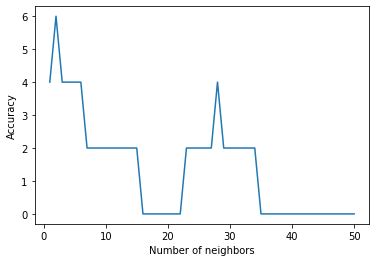

Highest acc of 6.0, with 2 neighbours


In [124]:
# plot accuracy_k
x_labels = [item[0] for item in accuracy_k]
y_labels = [item[1] for item in accuracy_k]
plt.plot(x_labels, y_labels)
plt.xlabel('Number of neighbors')
plt.ylabel('Accuracy')
plt.show()

# get top accuracy lowest k or highest k
top_k = max(accuracy_k, key=lambda x:x[1])
print("Highest acc of {}, with {} neighbours".format(top_k[1], top_k[0]))

In [122]:
# process all test images
image_path_test = ["test_set/"+file for file in os.listdir("test_set")]

test_images = []

for i, image_path in enumerate(image_path_test):
  image = cv2.imread(image_path)
  features = image_to_feature(image)
  test_images.append(features)

  # show update every 100 images
  if i > 0 and i % 100 == 0:
    print("Processed {}/{}".format(i, len(image_paths)))

Processed 100/500
Processed 200/500


In [154]:
# get predictions for our choice of k
model = KNeighborsClassifier(n_neighbors=top_k[0])
model.fit(trainRI, trainL)
predictions = model.predict(test_images)

# put prediction csv together
image_names = [image[9:] for image in image_path_test]

data = list(zip(image_names, predictions))
df = pd.DataFrame(data, columns=['img_name', 'label']).sort_values(by='img_name')

# put test labels in csv file
#df.to_csv("predictions/predictions_knn.csv")

In [155]:
df

,img_name,label
8,test_1.jpg,35
21,test_10.jpg,37
9,test_100.jpg,1
20,test_1000.jpg,24
16,test_1001.jpg,30
...,...,...
237,test_1232.jpg,45
250,test_1233.jpg,24
235,test_1234.jpg,24
239,test_1235.jpg,8
